In [1]:
%matplotlib inline
from matplotlib import style
# style.use('fivethirtyeight')
style.use('seaborn')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import date, timedelta, datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# Create engine using the `hawaii.sqlite` database file

engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table

Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB

session = Session(engine)

In [12]:
# Show first row in the Measurement table

first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f8cb8fd7550>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'tobs': 65.0,
 'id': 1,
 'date': '2010-01-01'}

In [13]:
# Show first row in the Station table

first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f8cb8fdf410>,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168}

# Exploratory Climate Analysis

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Retrieve the most recent date from the Measurement table

ret_date = engine.execute('SELECT MAX(date) FROM Measurement').fetchall()
ret_date

[('2017-08-23',)]

In [38]:
# Calculate the date 1 year ago from the last data point in the database

data = engine.execute('SELECT * FROM Measurement WHERE date >= "2016-08-24" AND date <= "2017-08-23" \
                        ORDER BY date DESC').fetchall()


In [17]:
# Perform a query to retrieve the date and precipitation scores

date = []
prep = []

for i in data:
    date.append(i[2])
    prep.append(i[3])

for x in reversed(date):
    date_list = list(reversed(date))

        
for y in reversed(prep):
    prep_list = list(reversed(prep))
  

In [18]:
# Save the query results as a Pandas DataFrame and set the index to the date column

new_list = list(zip(date_list, prep_list))
new_list

data_df = pd.DataFrame(new_list)
final_df = data_df.rename(columns={0: "Date", 1: "Precipitation"})
date_index = final_df.set_index("Date")
date_index.head()

,Precipitation
Date,
2016-08-24,1.45
2016-08-24,2.15
2016-08-24,1.22
2016-08-24,NaN
2016-08-24,2.28


In [19]:
# Sort the dataframe by date

date_index.dropna(inplace=True)
date_index.sort_index().head()

,Precipitation
Date,
2016-08-24,1.45
2016-08-24,2.15
2016-08-24,1.22
2016-08-24,2.28
2016-08-24,2.15


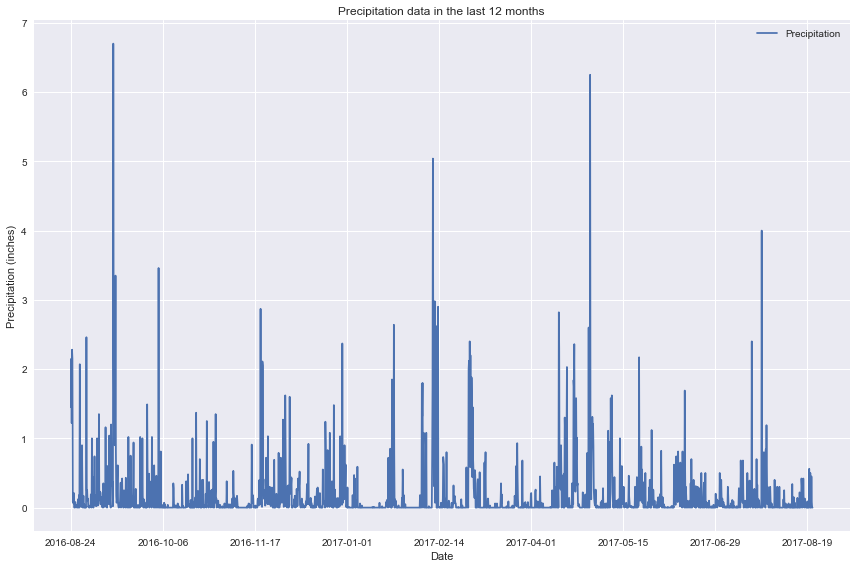

In [20]:
# Use Pandas Plotting with Matplotlib to plot the data

date_index.plot(title="Precipitation data in the last 12 months", figsize=(12,8))
plt.ylabel("Precipitation (inches)")
plt.tight_layout()
plt.show()

In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation data

date_index.describe().round(3)

,Precipitation
count,2015.000
mean,0.176
std,0.460
min,0.000
25%,0.000
50%,0.020
75%,0.130
max,6.700


In [22]:
# Design a query to show how many stations are available in this dataset?

stats_num = session.query(Station).distinct(Station.station).count()
stats_num

9

In [23]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

stats_count = session.query(Measurement.station, func.count(Measurement.station)).\
                group_by(Measurement.station).order_by(func.count(Measurement.station).\
                                                       desc()).all()

stats_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [24]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

stats_min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == stats_count[0][0]).all()
stats_max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == stats_count[0][0]).all()
stats_avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == stats_count[0][0]).all()

print(f'{"The lowest temperature recorded in the most active station, " + str(stats_count[0][0]) + ", is " + str(stats_min_temp[0][0])}')
print(f'{"The highest temperature recorded in the most active station, " + str(stats_count[0][0]) + ", is " + str(stats_max_temp[0][0])}')
print(f'{"The average temperature recorded in the most active station, " + str(stats_count[0][0]) + ", is " + str(round((stats_avg_temp[0][0]), 2))}')





The lowest temperature recorded in the most active station, USC00519281, is 54.0
The highest temperature recorded in the most active station, USC00519281, is 85.0
The average temperature recorded in the most active station, USC00519281, is 71.66


In [25]:
# Choose the station with the highest number of temperature observations.

stats_hi = stats_count[0][0]
stats_hi

'USC00519281'

In [26]:
# Query the last 12 months of temperature observation data for this station 

data_one = engine.execute('SELECT * FROM Measurement WHERE station = "USC00519281" AND \
                        date >= "2016-08-24" AND date <= "2017-08-23" ORDER BY date DESC').fetchall()
data_one


    # Create an empty list to store the values of temperature in the station for the last 12 months
stats_temp = []

for i in data_one:
    stats_temp.append(i[4])
    

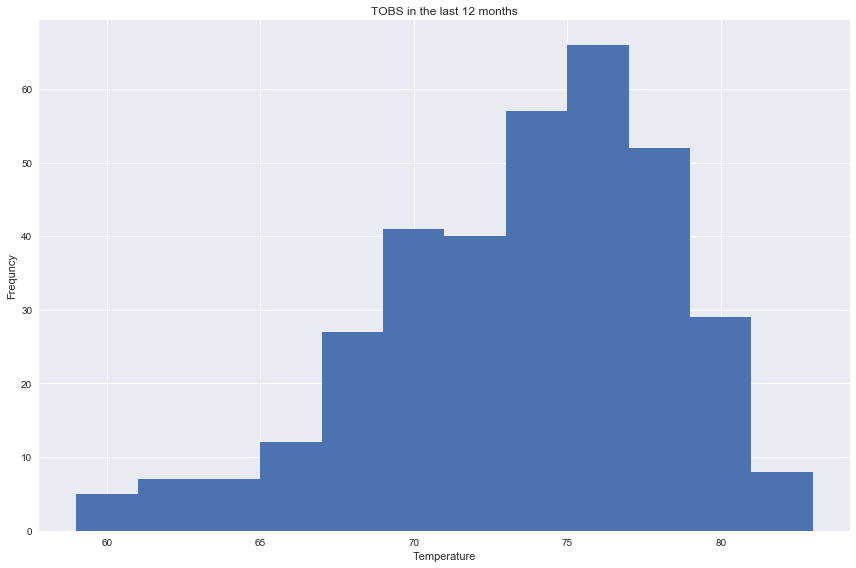

In [27]:
# plot the results as a histogram

plt.figure(figsize=(12,8))
plt.hist(stats_temp, bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequncy')
plt.title('TOBS in the last 12 months')
plt.tight_layout()
plt.show()

## Bonus Challenge Assignment

In [28]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates


def calc_temps(start_date, end_date):   
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()



# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))


[(62.0, 69.57142857142857, 74.0)]


In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


temp_values = calc_temps('2016-12-15', '2016-12-25')
print(calc_temps('2016-12-15', '2016-12-25'))

[(60.0, 71.52112676056338, 78.0)]


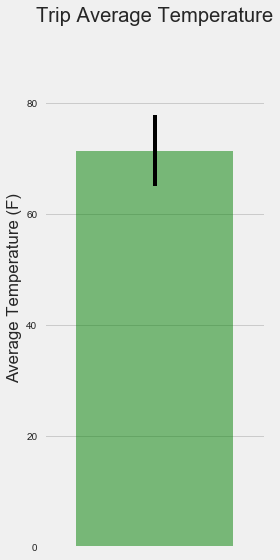

In [30]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(4, 8))
y = temp_values[0][1]
x_pos = 1
error = temp_values[0][2] - temp_values[0][1]
bar = ax.bar(x_pos, y, yerr=error, alpha=0.5, color='green', align='center')
ax.set(xticks=range(x_pos), xticklabels="a", title="Trip Average Temperature", ylabel="Average Temperature (F)")
ax.margins(.2, .2)
plt.tight_layout()
plt.show()


In [31]:
# Calculate the total amount of rainfall per weather station for your trip dates 
# using the previous year's matching dates.

# Sort this in descending order by precipitation amount and list the station, name, 
# latitude, longitude, and elevation


start_date = '2016-12-15'
end_date = '2016-12-25'


stats_trip_data = session.query(Station.station, Station.name, Station.latitude, Station.longitude,
                                Station.elevation, func.sum(Measurement.prcp)).\
                    filter(Measurement.station == Station.station).\
                    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
                    group_by(Station.station).order_by(func.sum(Measurement.prcp).desc()).all()
stats_trip_data


[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  4.26),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  1.8599999999999999),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  1.1300000000000001),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.74),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.41000000000000003),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  0.18000000000000005),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.06)]

In [32]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")[0]

(62.0, 69.15384615384616, 77.0)

In [33]:
# calculate the daily normals for your trip

# push each tuple of calculations into a list called `normals`

normals  = []



# Set the start and end date of the trip

start_date = '2016-12-15'
end_date = '2016-12-25'



# Use the start and end date to create a range of dates

trip_day_list = pd.date_range(start_date,end_date)



# Stip off the year and save a list of %m-%d strings

date_time = trip_day_list.strftime('%m-%d')



# Loop through the list of %m-%d strings and calculate the normals for each date

for i in date_time:
    normals.append(daily_normals(i)[0])
    

normals

[(62.0, 71.34, 79.0),
 (60.0, 69.62264150943396, 82.0),
 (63.0, 70.64, 77.0),
 (63.0, 71.28, 77.0),
 (67.0, 72.0, 78.0),
 (65.0, 72.91304347826087, 81.0),
 (67.0, 72.13953488372093, 78.0),
 (67.0, 71.1304347826087, 77.0),
 (61.0, 70.34693877551021, 78.0),
 (62.0, 70.0625, 78.0),
 (60.0, 71.75, 79.0)]

In [34]:
# Store the values of minimum, maximum, average temperature in separate lists

tmin = []
tmax = []
tavg = []

for a in normals:
    tmin.append(a[0])
    tmax.append(a[1])
    tavg.append(a[2])


In [35]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range

trip_data = pd.DataFrame([trip_day_list, tmin, tmax, tavg]).T
trip_data

,0,1,2,3
0,2016-12-15,62,71.34,79
1,2016-12-16,60,69.6226,82
2,2016-12-17,63,70.64,77
3,2016-12-18,63,71.28,77
4,2016-12-19,67,72,78
5,2016-12-20,65,72.913,81
6,2016-12-21,67,72.1395,78
7,2016-12-22,67,71.1304,77
8,2016-12-23,61,70.3469,78
9,2016-12-24,62,70.0625,78


In [36]:
# Rename column names and set 'Trip Dates' as index

trip_data.rename(columns={0: 'Trip Dates', 1: 'Min', 2: 'Max', 3:'Avg'}, inplace=True)
trip_data.set_index('Trip Dates', inplace=True)
trip_data

,Min,Max,Avg
Trip Dates,,,
2016-12-15,62,71.34,79
2016-12-16,60,69.6226,82
2016-12-17,63,70.64,77
2016-12-18,63,71.28,77
2016-12-19,67,72,78
2016-12-20,65,72.913,81
2016-12-21,67,72.1395,78
2016-12-22,67,71.1304,77
2016-12-23,61,70.3469,78


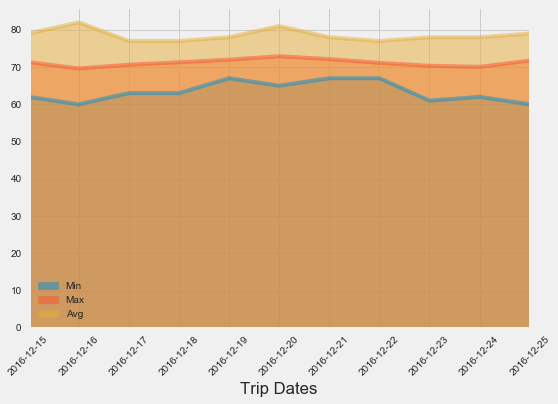

In [37]:
# Plot the daily normals as an area plot with `stacked=False`

trip_data.plot(kind='area', stacked=False, rot=45)
tick_values = trip_data.index.strftime('%Y-%m-%d')
plt.xticks(ticks=trip_data.index, labels=tick_values)
plt.show()